In [1]:
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error as MSE

plt.rcParams["figure.figsize"] = (20, 6)

# Parameters

In [2]:
N = 40
F = 8.0
x0 = F * np.ones(N)
x0[0] += 0.01

In [ ]:
def l96_model(x):
    d = np.zeros(N)
    for i in range(N):
        d[i] = (x[(i+1)%N] - x[i-2]) * x[i-1] - x[i] + F
    return d


def l96_step(x, dt):
    k1 = l96_model(x) * dt
    k2 = l96_model(x + k1/2) * dt
    k3 = l96_model(x + k2/2) * dt
    k4 = l96_model(x + k3) * dt
    x = x + (k1 + 2 * k2 + 2 * k3 + k4) / 6
    return x


In [4]:
def l96_loop(x0, t_end):
    t = 0.0
    dt = 0.01
    x_ls = []
    x_ls.append(x0)
    x = x0

    while(t + dt<= t_end):
        x = l96_step(x, dt)
        x_ls.append(x)
        t += dt
    x_ls = np.array(x_ls)
    return x_ls
def l96_jump(x0, t_end):
    return l96_loop(x0, t_end)[-1]
def l96_one(x0):
    return l96_loop(x0, 0.01)[-1]
def l96_synoptic(x0):
    return l96_loop(x0, 0.05)[-1]

In [5]:
x_ls = l96_loop(x0, 10.0)

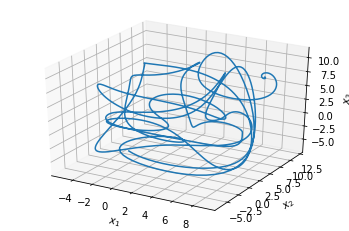

In [6]:
# Plot the first three variables
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(x_ls[:, 0], x_ls[:, 1], x_ls[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

## リアプノフ指数の計算
正確にやるためには何が必要？

->　アトラクター上の様々な点から計測する

とりあえず1年分スピンアップで捨てた後ノイズを加えたものと加えていないものの誤差を測定する

In [7]:
year = 73.0
ly_data = l96_loop(x0, 10 * year)

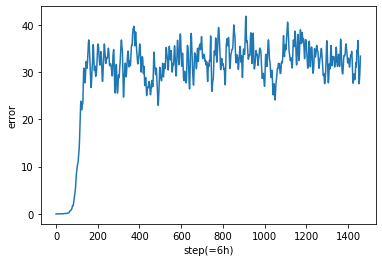

In [8]:
y = 1.0
#while y <= 10.0:
base = ly_data[int(y * year * 100)]
noise = np.zeros_like(base)
noise[0] += 0.01
out = l96_loop(base, year) - l96_loop(base+noise, year)
out = np.linalg.norm(out,axis=1)
plt.plot(out[::5])
plt.xlabel('step(=6h)')
plt.ylabel('error')
plt.show()



<function matplotlib.pyplot.show(*args, **kw)>

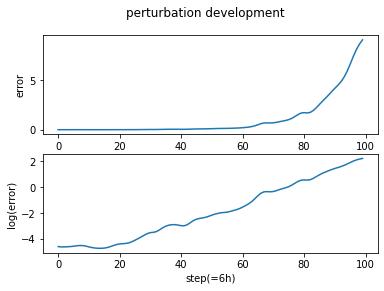

In [9]:
out_zoom = out[:500]
out_zoom = out_zoom[::5]
fig, ax = plt.subplots(2)
fig.suptitle('perturbation development')
ax[0].plot(out_zoom)
ax[1].plot(np.log(out_zoom))
ax[1].set_xlabel('step(=6h)')
ax[0].set_ylabel('error')
ax[1].set_ylabel('log(error)')
plt.show

リアプノフ指数>0であることがわかった。つまりカオス。

しかし200step付近で誤差の成長が止まる。この誤差は２つの適当なアトラクターの平均的な差に当たるものだと考える。

# 2年分足し合わせる
2 * 365 * 4 * 0.05 = 146.0 step必要

In [10]:
twoy = 146.0
data = l96_loop(x0, twoy)
print(data.shape)
data = data[::5] # 6hごとに圧縮
data = data[int(data.shape[0]/2):] # ２年めのみを使う
print(data.shape)

(14600, 40)
(1460, 40)


In [11]:
print(data[0])

[ 3.73972009  5.0818905   1.8831919  -2.96759682  2.09667497  2.91926057
 10.26754184 -2.61767505 -1.20824939 -0.99769068  2.17496582  6.47420229
  1.27741554 -3.35782869 -0.17156987 -5.28834285 -0.36133256  9.38708514
  7.02829646  6.1431077   4.03196919 -2.69435818  3.45771701 11.95515543
  1.45649789 -1.06537432  1.35330969 -0.17528414  2.55640281  6.3852554
  6.18010162  1.696851   -1.87662797 -0.11911194  4.66623823  9.10878121
  0.22889094  1.16859856 -1.66642582  1.60676217]


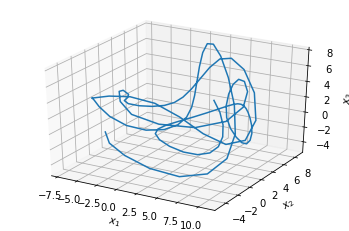

In [12]:
# Plot the first three variables
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(data[:100, 0], data[:100, 1], data[:100, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()

[ 0.93735282 -0.72323813  1.22246206  0.99151114 -2.47894697 -0.7368486
 -1.24583756 -0.51442804 -1.05249893 -1.02044562 -0.25100814 -1.80477517
 -0.63945038 -0.06860907  1.82526044 -0.34724494  0.17370859 -0.26204334
  0.26012241  1.01934647 -0.86457149  0.33793458  0.34543963 -0.41914536
  1.30093773 -1.25724456  0.85582252 -1.04220932 -1.59619164  0.34750802
 -0.76759602 -0.02679952  1.41962364  0.14939059 -0.64457882  2.54240093
  0.826016   -1.53978295  1.89003694 -1.17301196]


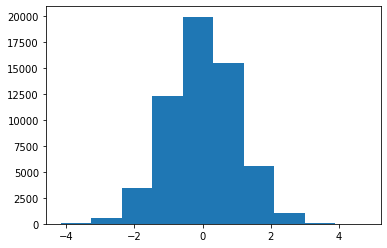

In [13]:
random_ls = np.random.randn(data.shape[0], data.shape[1])
print(random_ls[0])
plt.hist(np.ravel(random_ls))
plt.show()

In [14]:
data_noise = data + random_ls
np.savetxt("data.txt", data)
np.savetxt("data_noise.txt", data_noise)

In [7]:
# if data exists
data_noise = np.loadtxt("data_noise.txt")
data = np.loadtxt("data.txt")

# KF

In [8]:
a = 25
delta = 0.001

In [9]:
x_s = data_noise[0]
p_s = a * np.eye(N)


In [30]:
x_a = x_s
p_a = p_s
H = np.eye(N)
R = np.eye(N)
error_x_ls = []
p_ls = []
noise_ls = []
error_x_ls.append(np.sqrt(MSE(x_a, data[0])))
p_ls.append(np.trace(p_a))
noise_ls.append(np.sqrt(MSE(data_noise[0], data[0])))
for i in range(1, data_noise.shape[0]):
    if i % 200 == 0:
        print(i)
    m = np.zeros((N, N))
    for j in range(0, N):
        e_j = np.zeros((N))
        e_j[j] = delta
        m[:, j] = (l96_one(x_a + e_j) - l96_one(x_a)) / delta
    #m = m.T
    #print(m)
    x_f = l96_synoptic(x_a)
    p_f = m @ p_a @ m.T
    #print(x_f)
    #print(p_f)
    K = p_f @ H.T @ np.linalg.inv(H @ p_f @ H.T + R)
    x_a = x_f + K @ (data_noise[i] - H @ x_f)
    p_a = (np.eye(N) - K @ H) @ p_f
    p_a = p_a * 1.1
    error_x_ls.append(np.sqrt(MSE(x_a, data[i])))
    p_ls.append(np.trace(p_a))
    noise_ls.append(np.sqrt(MSE(data_noise[i], data[i])))

200
400
600
800
1000
1200
1400


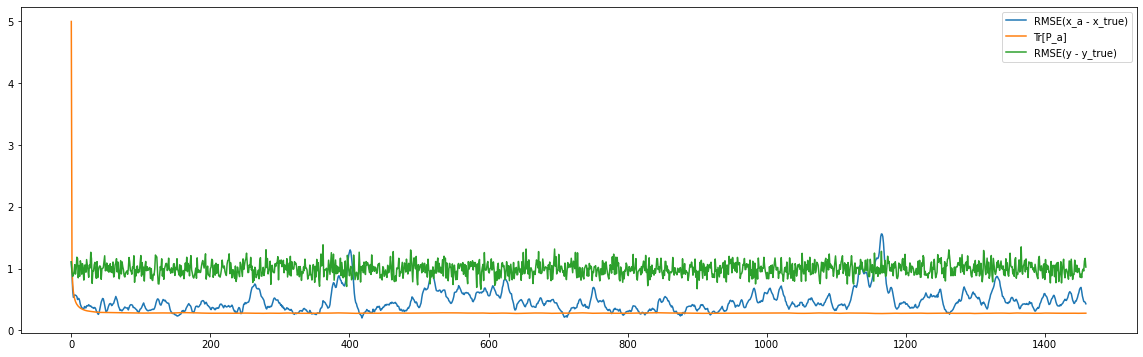

In [31]:
error_x_np = np.array(error_x_ls)
p_np = np.sqrt(np.array(p_ls) / N)
noise_np = np.array(noise_ls)
plt.plot(error_x_np, label="RMSE(x_a - x_true)")
plt.plot(p_np, label="Tr[P_a]")
plt.plot(noise_np, label="RMSE(y - y_true)")
plt.legend()
plt.savefig("kf_param.png")
plt.show()


### 